## Time Series Anomaly Detection

### Table of Contents
* [Section 1: What Are Anomalies in a Time Series?](#section1)
* [Section 2: Simple Moving Average](#section2)
* [Section 3: Exponential Moving Average](#section3)
* [Section 4: Seasonal-Trend Decomposition](#section4)
* [Section 5: Facebook's Prophet](#section5)



Reading:
* [Forecasting at Scale](https://peerj.com/preprints/3190.pdf)
* Bike share daily count: [data](https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike-sharing-daily.csv)

### (1) What Are Anomalies in a Time Series?

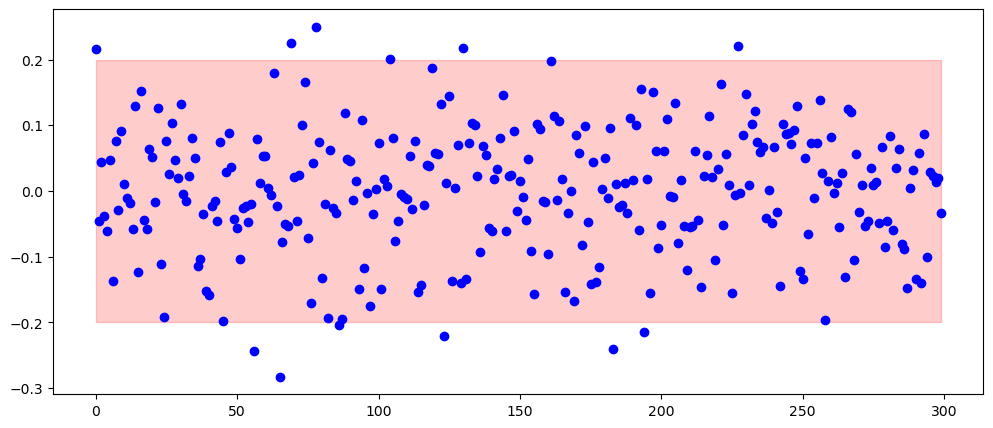

In [1]:
# Generate the data
import numpy as np
import matplotlib.pyplot as plt 

# A time series
mu, sigma = 0, 0.1 # mean and standard deviation
obs = 300
plt.figure(figsize=[12, 5])
plt.plot(np.random.normal(mu, sigma, obs), marker = 'o',linestyle='', color='b')
plt.fill_between(np.arange(obs), -2*sigma, 2*sigma, alpha=0.2, color="r", label="Predicted interval")
plt.show()

Cautions:
- Model patterns as noises
- Model noises as patterns

### (2) Simple Moving Average

In [5]:
import pandas as pd
import seaborn as sns
path = ''
bike = pd.read_csv(path + '/bike_sharing_daily.csv')
bike = bike[['dteday','cnt']]
bike.columns = ['ds','y']
bike.tail()

ds     y
726  2012-12-27  2114
727  2012-12-28  3095
728  2012-12-29  1341
729  2012-12-30  1796
730  2012-12-31  2729

<Axes: >

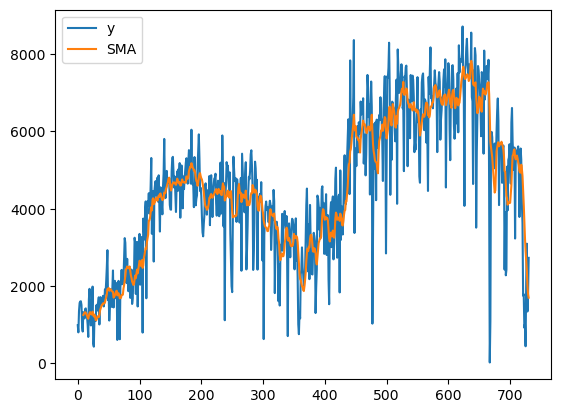

In [6]:
bike['SMA'] = bike.iloc[:,1].rolling(window=10).mean()
bike['diff'] = bike['y'] - bike['SMA']
bike[['y','SMA']].plot()

Text(0.5, 1.0, 'The distribution of diff')

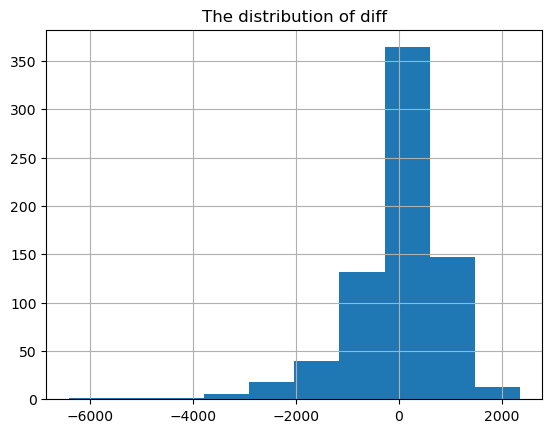

In [7]:
bike['diff'].hist()
plt.title('The distribution of diff')

In [8]:
bike['upper'] = bike['SMA'] + 2000
bike['lower'] = bike['SMA'] - 2000
bike[10:20]

ds     y     SMA   diff   upper  lower
10  2011-01-11  1263  1279.3  -16.3  3279.3 -720.7
11  2011-01-12  1162  1315.4 -153.4  3315.4 -684.6
12  2011-01-13  1406  1321.1   84.9  3321.1 -678.9
13  2011-01-14  1421  1307.0  114.0  3307.0 -693.0
14  2011-01-15  1248  1271.8  -23.8  3271.8 -728.2
15  2011-01-16  1204  1231.6  -27.6  3231.6 -768.4
16  2011-01-17  1000  1180.6 -180.6  3180.6 -819.4
17  2011-01-18   683  1153.0 -470.0  3153.0 -847.0
18  2011-01-19  1650  1235.8  414.2  3235.8 -764.2
19  2011-01-20  1927  1296.4  630.6  3296.4 -703.6

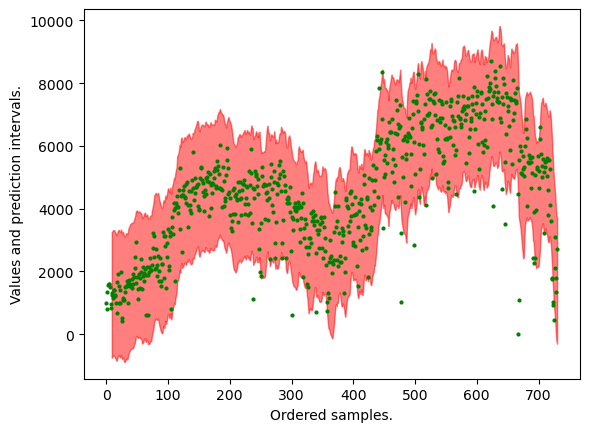

In [9]:
def plot_it():
    plt.plot(bike['y'],'go',markersize=2,label='Actual')
    plt.fill_between(
       np.arange(bike.shape[0]), bike['lower'], bike['upper'], alpha=0.5, color="r",
       label="Predicted interval")
    plt.xlabel("Ordered samples.")
    plt.ylabel("Values and prediction intervals.")
    plt.show()
    
plot_it()

### (3) Exponential Smoothing

<Axes: >

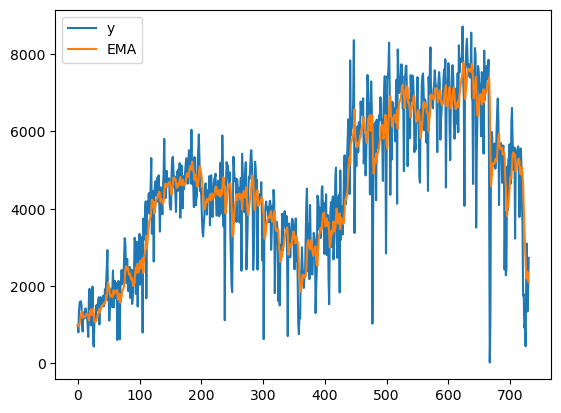

In [11]:
from statsmodels.tsa.api import SimpleExpSmoothing
import pandas as pd
import numpy as np
bike = pd.read_csv(path + '/bike_sharing_daily.csv')
bike = bike[['dteday','cnt']]
bike.columns = ['ds','y']

EMAfit = SimpleExpSmoothing(bike['y']).fit(smoothing_level=0.2,optimized=False)
EMA = EMAfit.forecast(3).rename(r'$\alpha=0.2$')
bike['EMA'] = EMAfit.predict(start = 0)
bike['diff'] = bike['y'] - bike['EMA']
bike[['y','EMA']].plot()

Text(0.5, 1.0, 'The distribution of diff')

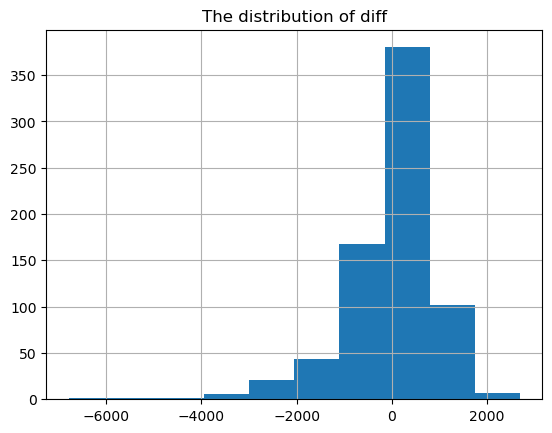

In [12]:
bike['diff'].hist()
plt.title('The distribution of diff')

In [13]:
bike['upper'] = bike['EMA'] + 2000
bike['lower'] = bike['EMA'] - 2000
bike[10:20]

ds     y          EMA        diff        upper       lower
10  2011-01-11  1263  1207.073629   55.926371  3207.073629 -792.926371
11  2011-01-12  1162  1218.258903  -56.258903  3218.258903 -781.741097
12  2011-01-13  1406  1207.007122  198.992878  3207.007122 -792.992878
13  2011-01-14  1421  1246.805698  174.194302  3246.805698 -753.194302
14  2011-01-15  1248  1281.644558  -33.644558  3281.644558 -718.355442
15  2011-01-16  1204  1274.915647  -70.915647  3274.915647 -725.084353
16  2011-01-17  1000  1260.732517 -260.732517  3260.732517 -739.267483
17  2011-01-18   683  1208.586014 -525.586014  3208.586014 -791.413986
18  2011-01-19  1650  1103.468811  546.531189  3103.468811 -896.531189
19  2011-01-20  1927  1212.775049  714.224951  3212.775049 -787.224951

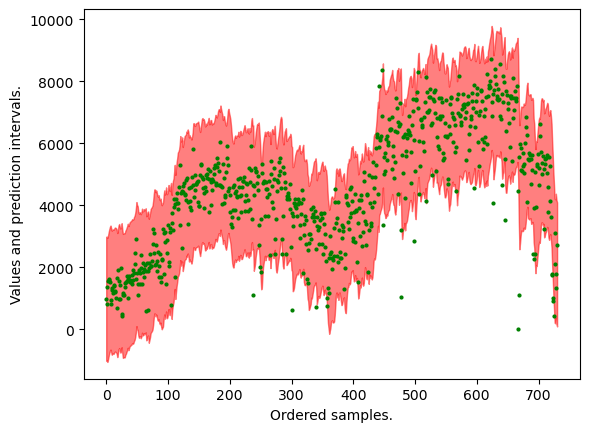

In [14]:
plot_it()

### Search for the optimal alpha

Best alpha: 0.0100, MSE: 3524703.8665


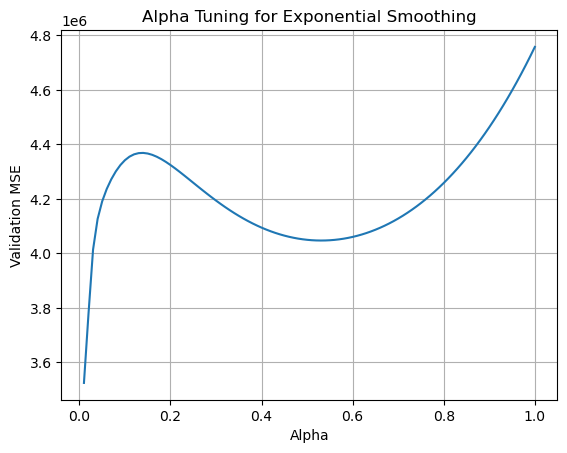

In [17]:
from sklearn.metrics import mean_squared_error

bike = pd.read_csv(path + '/bike_sharing_daily.csv')
bike = bike[['dteday','cnt']]
bike.columns = ['ds','y']

series = np.asarray(bike['y'])
# Split into train and validation
# Use 80% of the data for training, and the remaining 20% for validation.
train_size = int(len(series) * 0.8)
train, val = series[:train_size], series[train_size:]

# Define range of alpha values
alphas = np.linspace(0.01, 1.0, 100)  # creates 100 evenly spaced values between 0.01 and 1.0.
errors = [] # initializes a list to store the Mean Squared Error (MSE) for each alpha.

# Grid search over alpha values
for alpha in alphas:
    model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False) # initializes the model with the training data.
    forecast = model.forecast(len(val)) # generates forecasts for the length of the validation set.
    mse = mean_squared_error(val, forecast) # calculates how far off the predictions are.
    errors.append(mse) # Append the error to the errors list.
                                            
# Get best alpha
best_alpha = alphas[np.argmin(errors)]
print(f"Best alpha: {best_alpha:.4f}, MSE: {min(errors):.4f}")

# Plot MSE vs alpha
plt.plot(alphas, errors)
plt.xlabel('Alpha')
plt.ylabel('Validation MSE')
plt.title('Alpha Tuning for Exponential Smoothing')
plt.grid(True)
plt.show()


### (4) Seasonal-Trend Decomposition

<AxesSubplot:xlabel='ds'>

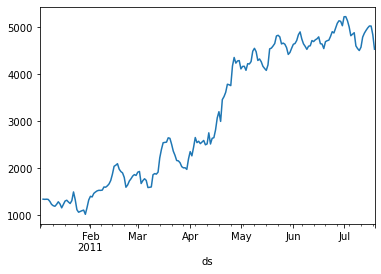

In [11]:
import pandas as pd
import statsmodels.api as sm

bike = pd.read_csv(path + '/bike-sharing-daily.csv')
bike = bike[['dteday','cnt']]
bike.columns = ['ds','y']
bike = bike.reset_index(drop='index') #inplace=True)
bike.index = pd.to_datetime(bike['ds'])

result = sm.tsa.seasonal_decompose(bike['y'], model='additive')
result.trend[1:200].plot()

<AxesSubplot:xlabel='ds'>

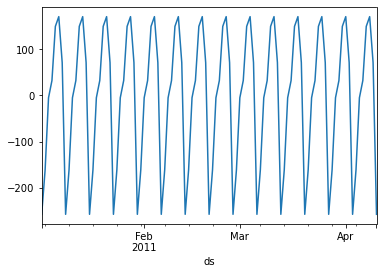

In [12]:
result.seasonal[1:100].plot()

<AxesSubplot:xlabel='ds'>

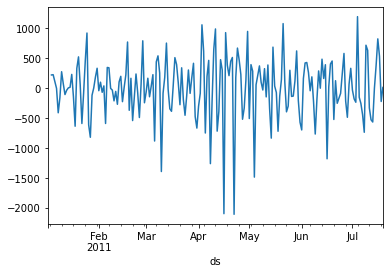

In [13]:
result.resid[1:200].plot()

<AxesSubplot:xlabel='ds'>

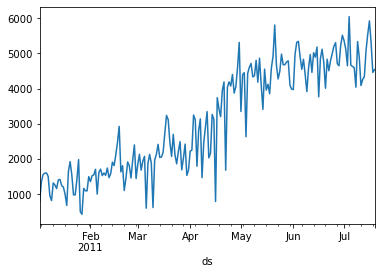

In [14]:
result.observed[1:200].plot()

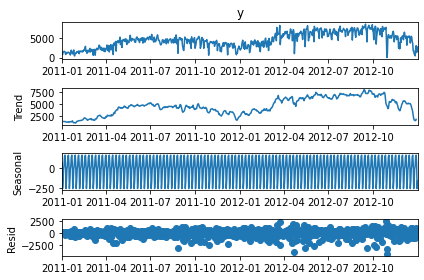

In [15]:
result.plot()
plt.show()

### (5) Facebook's Prophet

In [16]:
# !pip install fbprophet
# Or use "conda install -c conda-forge/label/cf202003 fbprophet"
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline

# Fitting with default parameters
bike_model_0 = Prophet(daily_seasonality=True)
bike_model_0.fit(bike)

In [17]:
future= bike_model_0.make_future_dataframe(periods=20, freq='d')
future.tail()

ds
746 2013-01-16
747 2013-01-17
748 2013-01-18
749 2013-01-19
750 2013-01-20

In [18]:
bike_model_0_data=bike_model_0.predict(future)
bike_model_0_data.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
746 2013-01-16  5423.609662  4218.189478  6603.386259  5423.035659   
747 2013-01-17  5428.193126  4306.026832  6690.318004  5427.549916   
748 2013-01-18  5432.776591  4346.949159  6825.673018  5432.085642   
749 2013-01-19  5437.360055  4171.647779  6699.337834  5436.577140   
750 2013-01-20  5441.943520  3915.520401  6474.178956  5441.068882   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
746  5424.155585     -101.926469           -101.926469           -101.926469   
747  5428.825600       52.981474             52.981474             52.981474   
748  5433.506454      104.377813            104.377813            104.377813   
749  5438.182184       29.387044             29.387044             29.387044   
750  5442.834438     -279.408892           -279.408892           -279.408892   

           daily  ...      weekly  weekly_lower  weekly_upper       yearly  \
746  1113.008497  ...   35.806185     35.806185     35.806185 -1250.741151   
747  1113.008497  ...  149.113701    149.113701    149.113701 -1209.140724   
748  1113.008497  ...  166.760965    166.760965    166.760965 -1175.391648   
749  1113.008497  ...   65.653441     65.653441     65.653441 -1149.274893   
750  1113.008497  ... -262.004633   -262.004633   -262.004633 -1130.412755   

     yearly_lower  yearly_upper  multiplicative_terms  \
746  -1250.741151  -1250.741151                   0.0   
747  -1209.140724  -1209.140724                   0.0   
748  -1175.391648  -1175.391648                   0.0   
749  -1149.274893  -1149.274893                   0.0   
750  -1130.412755  -1130.412755                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper         yhat  
746                         0.0                         0.0  5321.683193  
747                         0.0                         0.0  5481.174601  
748                         0.0                         0.0  5537.154404  
749                         0.0                         0.0  5466.747100  
750                         0.0                         0.0  5162.534628  

[5 rows x 22 columns]

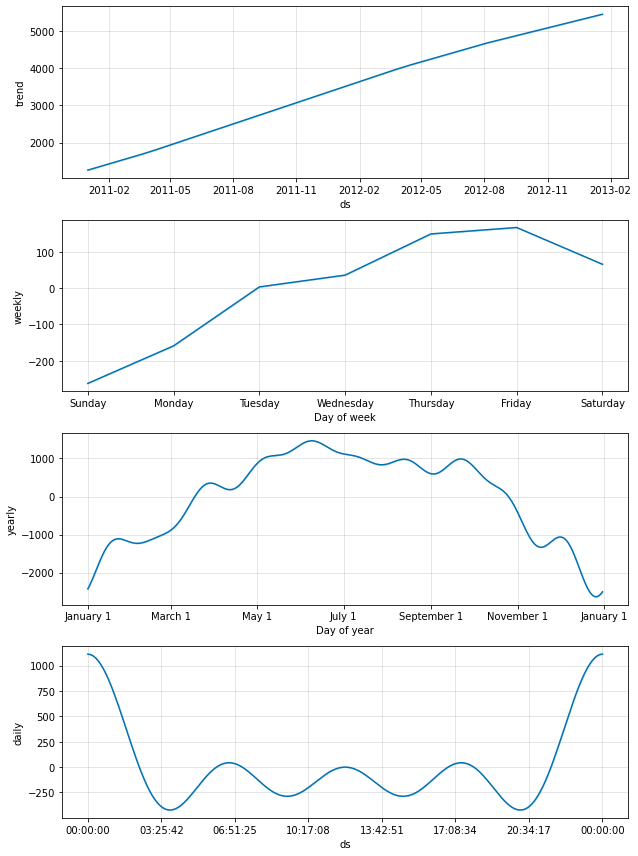

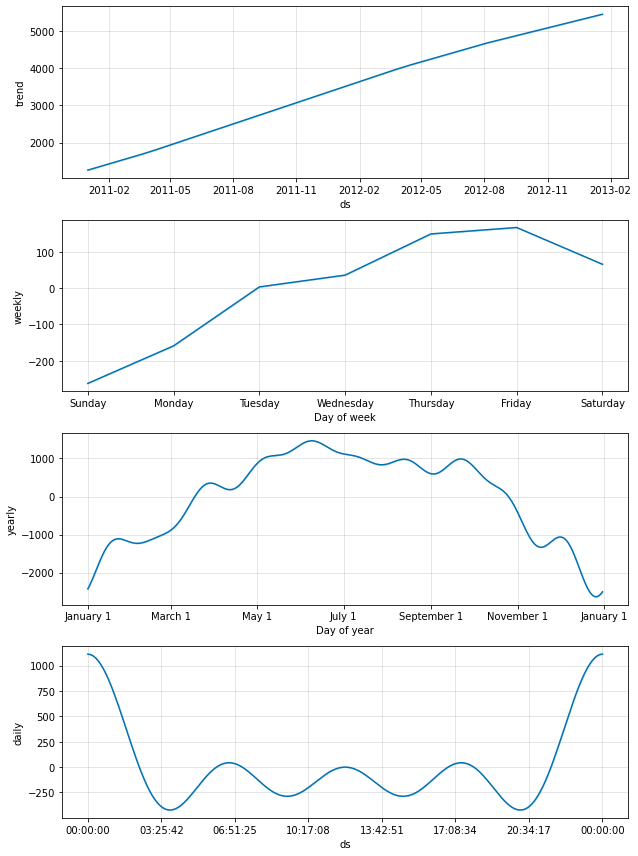

In [19]:
bike_model_0.plot_components(bike_model_0_data)

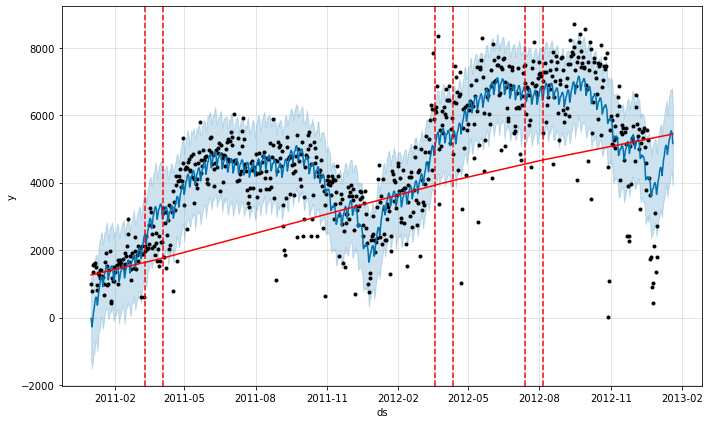

In [20]:
from fbprophet.plot import add_changepoints_to_plot
bike_model_0 = Prophet(daily_seasonality=True, #n_changepoints=20, 
                  #yearly_seasonality=True, 
                  #changepoint_prior_scale=0.05
                   )
forecast = bike_model_0.fit(bike).predict(future)
fig= bike_model_0.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), bike_model_0, forecast)

In [21]:
#bike_model_0.plot_components(bike_model_0_data)

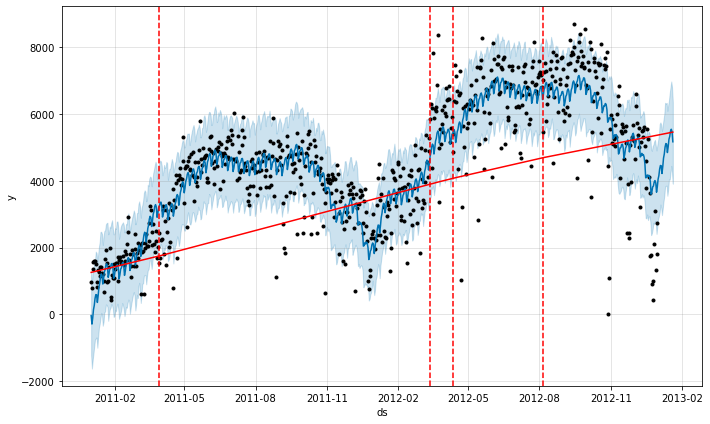

In [22]:
bike_model_2 = Prophet(daily_seasonality=True, n_changepoints=20, 
                  yearly_seasonality=True, 
                  changepoint_prior_scale=0.05
                   )
forecast = bike_model_2.fit(bike).predict(future)
fig= bike_model_2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), bike_model_2, forecast)

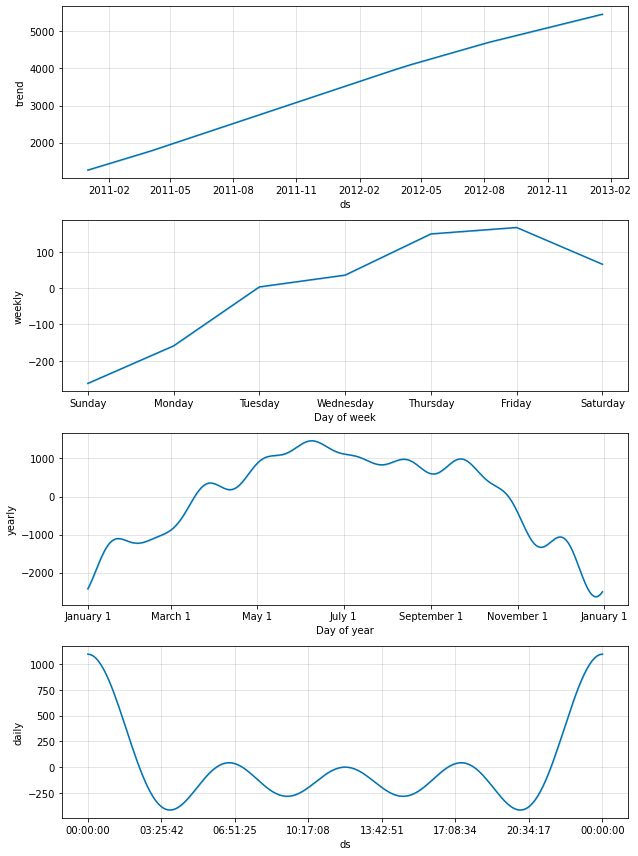

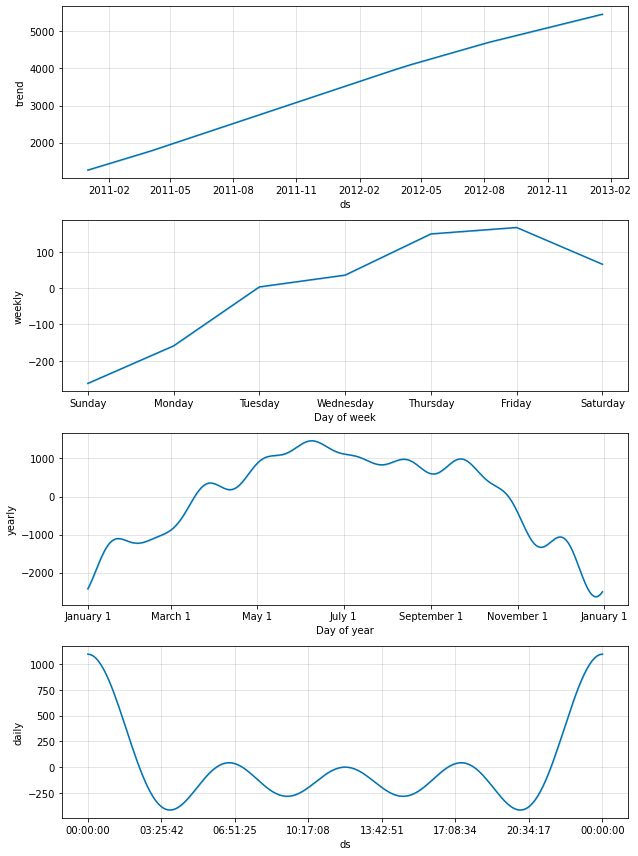

In [23]:
bike_model_2.plot_components(forecast)

In [24]:
# Python
from fbprophet.diagnostics import cross_validation
bike_0_cv = cross_validation(bike_model_0, 
                         initial='100 days', 
                         period='180 days', 
                         horizon = '365 days')
bike_0_cv.head()

INFO:fbprophet:Making 2 forecasts with cutoffs between 2011-07-05 00:00:00 and 2012-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

ds         yhat   yhat_lower   yhat_upper     y     cutoff
0 2011-07-06  5220.625036  4570.736705  5873.505572  4629 2011-07-05
1 2011-07-07  5355.605182  4730.695350  6030.828325  4592 2011-07-05
2 2011-07-08  5409.551258  4755.149484  6016.978193  4040 2011-07-05
3 2011-07-09  5384.833880  4688.940871  5962.228171  5336 2011-07-05
4 2011-07-10  5314.029336  4712.225439  5971.451692  4881 2011-07-05

In [25]:
# Python
from fbprophet.diagnostics import cross_validation
bike_2_cv = cross_validation(bike_model_2, 
                         initial='100 days', 
                         period='180 days', 
                         horizon = '365 days')
bike_2_cv.head()

INFO:fbprophet:Making 2 forecasts with cutoffs between 2011-07-05 00:00:00 and 2012-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

ds         yhat   yhat_lower   yhat_upper     y     cutoff
0 2011-07-06  5217.441016  4585.258562  5840.822686  4629 2011-07-05
1 2011-07-07  5351.887270  4689.650168  5989.353042  4592 2011-07-05
2 2011-07-08  5404.287762  4766.238928  6033.650974  4040 2011-07-05
3 2011-07-09  5377.493315  4756.544188  6009.443449  5336 2011-07-05
4 2011-07-10  5303.581351  4661.823702  5920.621724  4881 2011-07-05

In [26]:
bike_2_cv.tail()

ds         yhat   yhat_lower   yhat_upper     y     cutoff
725 2012-12-27  2865.569662  2055.614775  3739.760497  2114 2012-01-01
726 2012-12-28  2962.314270  2131.500340  3817.382315  3095 2012-01-01
727 2012-12-29  2849.488610  1966.421036  3696.307444  1341 2012-01-01
728 2012-12-30  2803.357435  2018.141229  3657.082296  1796 2012-01-01
729 2012-12-31  2823.164135  1944.274884  3744.378566  2729 2012-01-01

In [27]:
# Python
from fbprophet.diagnostics import performance_metrics
bike_0_p = performance_metrics(bike_0_cv)
bike_0_p.head()

horizon           mse         rmse          mae      mape     mdape  \
0 37 days  1.301328e+06  1140.757564   964.867203  0.253482  0.235163   
1 38 days  1.308574e+06  1143.928983   971.086830  0.254623  0.235163   
2 39 days  1.353034e+06  1163.199856   994.719532  0.260275  0.261513   
3 40 days  1.402677e+06  1184.346474  1017.417855  0.265661  0.279167   
4 41 days  1.406496e+06  1185.957633  1022.488488  0.267898  0.279167   

   coverage  
0  0.356164  
1  0.349315  
2  0.335616  
3  0.321918  
4  0.321918

In [28]:
# Python
from fbprophet.diagnostics import performance_metrics
bike_2_p = performance_metrics(bike_2_cv)
bike_2_p.head()

horizon           mse         rmse          mae      mape     mdape  \
0 37 days  1.662181e+06  1289.256037  1100.927172  0.292500  0.289643   
1 38 days  1.674576e+06  1294.054107  1111.979473  0.295430  0.289643   
2 39 days  1.730582e+06  1315.515872  1137.698024  0.301181  0.291473   
3 40 days  1.786449e+06  1336.580962  1161.925307  0.306646  0.295949   
4 41 days  1.776495e+06  1332.852032  1159.428576  0.305958  0.295949   

   coverage  
0  0.356164  
1  0.349315  
2  0.335616  
3  0.321918  
4  0.321918

### (6) RNN/LSTM/GRU


Read the article [A Technical Guide on RNN/LSTM/GRU for Stock Price Prediction](https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346)